Development of optimisation code

In [1]:
import sys
sys.path.append('/Users/simon/git/molnet/code/')

In [2]:
import pylab as plt
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from mnet import *

In [21]:

# input_file = '/Users/simon/Dropbox/BioResearch/Meta_clustering/KRD/mzml sylvia/KRD26_ISP3.mzML'
input_file = '/Users/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/multifile_ms2lda_manuscript/Supporting_Files/data/beers/Beer_multibeers_10_T10_POS.mzML'

Load the file

In [22]:
l = MNetLoadMZML(input_file,mz_tolerance = 0.2,rt_tolerance = 5,get_groups = True)
ms1,spectra = l.load_spectra()

Loading spectra from /Users/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/multifile_ms2lda_manuscript/Supporting_Files/data/beers/Beer_multibeers_10_T10_POS.mzML
Loaded 7312 spectra
After duplicate filtering, 573 spectra remain


For each of the spectra, find the most similar in the dataset that is not in the group

In [23]:
# make a dictionary to map the groups
group_dict = {}
for g in l.groups:
    for s in g:
        group_dict[s] = g

In [25]:
neg_hits = {}
pmz_tol = 5
rt_tol = 50
n_done = 0

n_matched = 2
ms2_mz_tol = 1.0

for s in spectra:
    best = None
    max_score = 0
    this_group = group_dict[s]
    for sp in spectra:
        if abs(s.precursor_mz - sp.precursor_mz) > pmz_tol:
            if abs(s.rt - sp.rt) > rt_tol:
                score,_ = fast_cosine(s,sp,ms2_mz_tol,n_matched)
                if score > max_score:
                    best = sp
                    max_score = score
    neg_hits[s] = (best,max_score)
    n_done += 1
#     if n_done == 2000:
#         break
    if n_done % 100 == 0:
        print n_done

100
200
300
400
500


In [26]:
from copy import deepcopy
import numpy as np
all_pos = {}
all_neg = {}
n_done = 0
ms2_vals = np.arange(0,20000,1000)
tol_vals = np.array([0.00001,0.0001,0.001,0.005,0.01,0.015,0.02,0.05,0.1,0.5])
min_peaks = np.array([1,2,3,4,5])
for mp in min_peaks:
    all_pos[mp] = {}
    all_neg[mp] = {}
    for spec1 in spectra:
        group = group_dict[spec1]
        found = False
        for eg_pos in group:
            if not eg_pos == spec1:
                found = True
                break
        if found:
            pass # fix this!!
        eg_neg = neg_hits[spec1][0]
    #     print ms2_vals
        # ms2_vals = [0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,20000]
        s_pos = []
        s_neg = []
        all_m_vals = []
        all_t_vals = []
        for m in ms2_vals:
            p1 = deepcopy(spec1)
            p2 = deepcopy(eg_pos)
            p3 = deepcopy(eg_neg)
            p1.remove_small_peaks(min_ms2_intensity = m)
            p2.remove_small_peaks(min_ms2_intensity = m)
            p3.remove_small_peaks(min_ms2_intensity = m)
            s_pos_t = []
            s_neg_t = []
            for t in tol_vals:
                s,_ = fast_cosine(p1,p2,t,mp)
                s_pos_t.append(s)
                s,_ = fast_cosine(p1,p3,t,mp)
                s_neg_t.append(s)
            s_pos.append(s_pos_t)
            s_neg.append(s_neg_t)
        all_pos[mp][spec1] = np.array(s_pos)
        all_neg[mp][spec1] = np.array(s_neg)
        n_done += 1
        if n_done % 100 == 0:
            print n_done

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800


Restructure the output to make it easier to work with

In [27]:
# we'd like a dictionary indexed by the different things we can vary that then has +ve and -ve spectral lists
n_spec = len(neg_hits)
restructured_results = {}
for mp in all_pos:
    restructured_results[mp] = {}
    for m in ms2_vals:
        restructured_results[mp][m] = {}
        for t in tol_vals:
            restructured_results[mp][m][t] = []

for mp in all_pos:
    sub_res = all_pos[mp]
    for spec,table in sub_res.items():
        # table is ms2 v tol
        for i,m in enumerate(ms2_vals):
            for j,t in enumerate(tol_vals):
                val = table[i,j]
                restructured_results[mp][m][t].append([val,all_neg[mp][spec][i,j]])



In [28]:
def compute_optimal_thresh(scores):
    thresh_vals = np.linspace(0,1,100)
    best_perf = 0
    best_thresh = 0
    scores = np.array(scores)
    for t in thresh_vals:
        perf = ((scores[:,0]>=t)*(scores[:,1]<t)).mean()
        if perf > best_perf:
            best_perf = perf
            best_thresh = t
    return best_perf,best_thresh

((3, 2000, 0.015), 0.9476439790575916, 0.888888888888889)


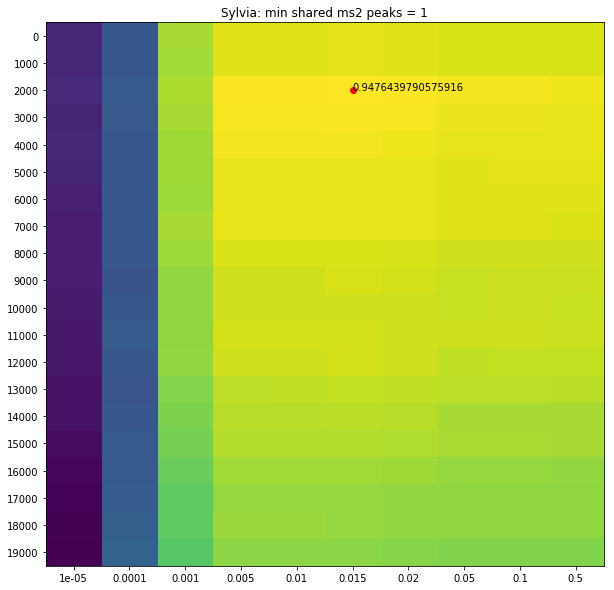

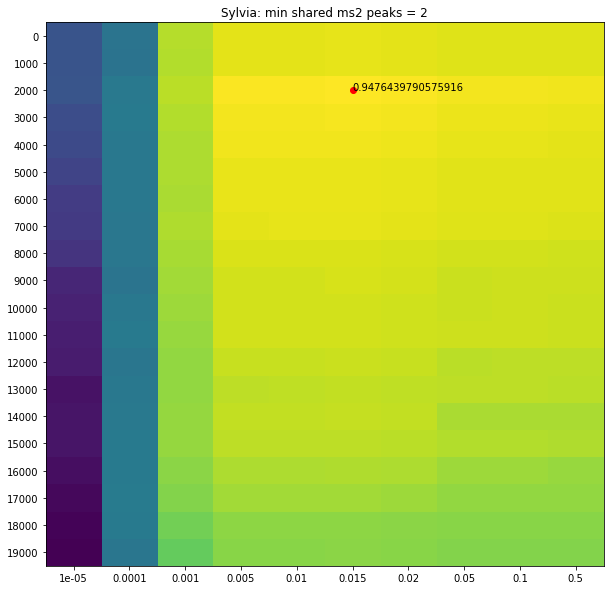

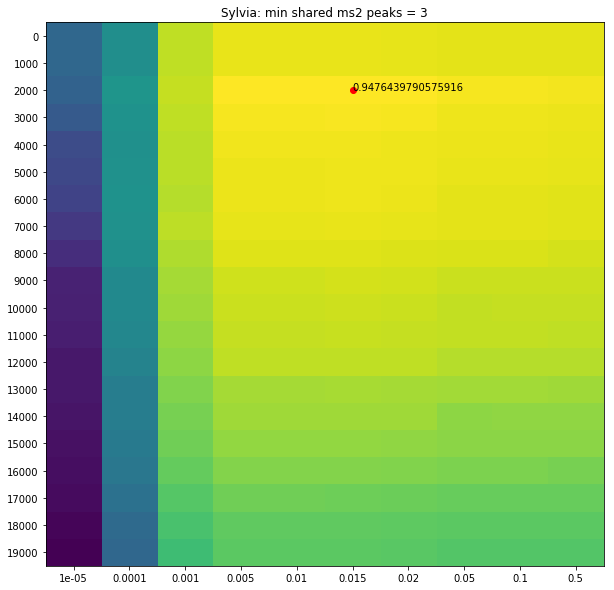

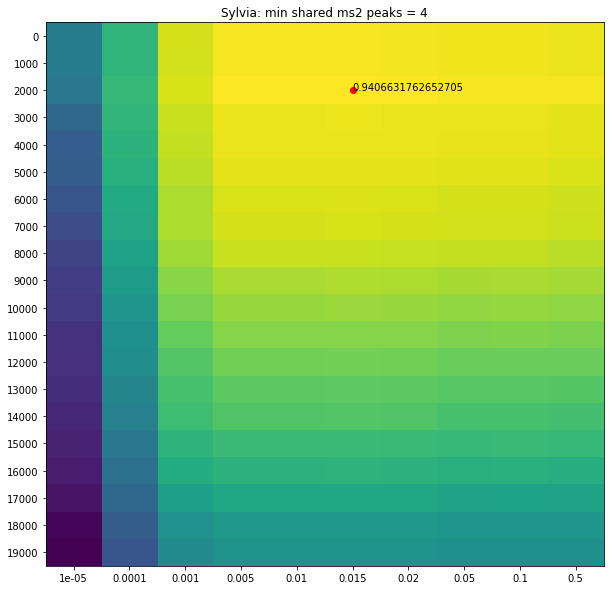

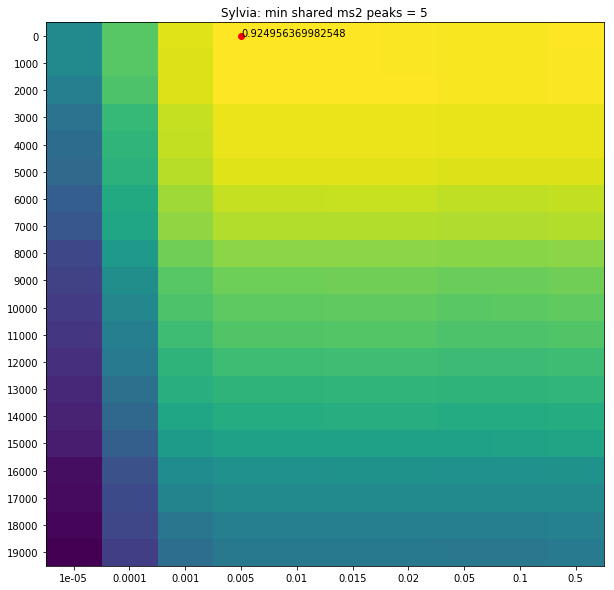

In [29]:
best = None,
best_score = 0
best_thresh = 0
# for mp in restructured_results:
grid = {}
for mp in min_peaks:  
    grid[mp] = np.zeros((len(ms2_vals),len(tol_vals)))
    for i,m in enumerate(ms2_vals):
        for j,t in enumerate(tol_vals):
            scores = restructured_results[mp][m][t]
            best_perf,bt = compute_optimal_thresh(scores)
            grid[mp][i,j] = best_perf
            if best == None:
                best = (mp,m,t)
                best_score = best_perf
                best_thresh = bt
            else:
                if best_perf >= best_score:
                    best = (mp,m,t)
                    best_score = best_perf
                    best_thresh = bt
print(best,best_score,best_thresh)
for mp in min_peaks:
    plt.figure(figsize=(10,10))
    plt.imshow(grid[mp],aspect='auto')
    pos = np.unravel_index(grid[mp].argmax(),grid[mp].shape)
    plt.plot(pos[1],pos[0],'ro')
    plt.text(pos[1],pos[0],grid[mp][pos[0],pos[1]])
    plt.xticks(range(len(tol_vals)),tol_vals)
    plt.yticks(range(len(ms2_vals)),ms2_vals)
    plt.title('Sylvia: min shared ms2 peaks = {}'.format(mp))
    plt.savefig('sylvia_{}.png'.format(mp))
# plt.imshow(grid[mp])

# 

# from mpl_toolkits.mplot3d import Axes3D
# X,Y = np.meshgrid(tol_vals,ms2_vals)
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
# print(X.shape,Y.shape,grid[mp].shape)
# ax.plot_surface(X,Y,grid[mp])
# ax.view_init(10, 45)

(14, 3)
(20, 10)
14000 0.001
0.6539701351367593
(12, 4)
(20, 10)
12000 0.01
0.629215261489111
(4, 3)
(20, 10)
4000 0.001
0.612258049756263
(4, 3)
(20, 10)
4000 0.001
0.5952874056282056
(3, 3)
(20, 10)
3000 0.001
0.568157684769321


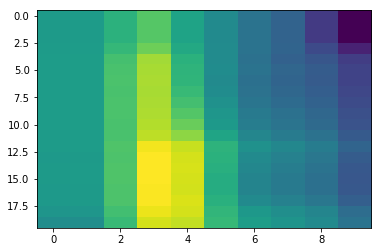

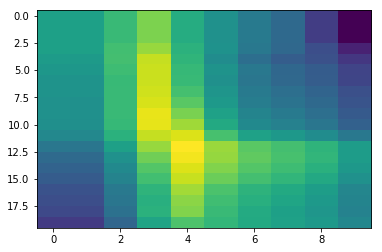

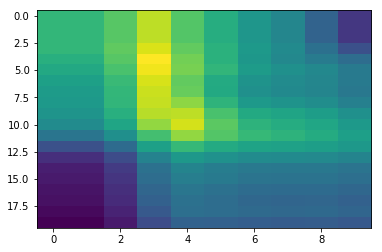

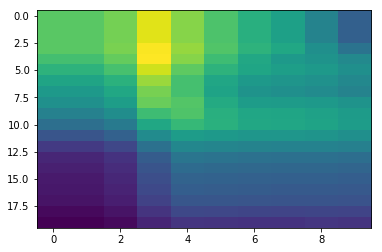

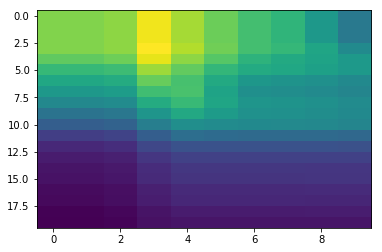

In [64]:
for mp in all_pos:
    eg = all_pos[mp][all_pos[mp].keys()[0]]
    mean_diff = np.zeros_like(eg)
    tot = 0
    for s in all_pos[mp]: # loop over spectra
        mean_diff += all_pos[mp][s] - all_neg[mp][s]
        tot += 1
    mean_diff /= tot
    plt.figure()
    plt.imshow(mean_diff,aspect='auto')
    best = 0
    best_pos = None
    for i,r in enumerate(mean_diff):
        for j,c in enumerate(r):
            if c > best:
                best_pos = (i,j)
                best = c
    print best_pos
    print mean_diff.shape
    print ms2_vals[best_pos[0]],tol_vals[best_pos[1]]
    print best

Do the initial filtering -- we're not optimising these bits

In [13]:
for s in spectra:
    s.remove_precursor_peak()
    s.keep_top_k()

In [14]:
from mnet_utilities import optimise_noise_thresh
from scoring_functions import *
ms2_vals = [0,1000,2000,3000,4000,5000,6000,7000,10000]
min_match_vals = [1,2,3,4,5,6]
all_pos_curves,all_neg_curves,all_auc_vals = optimise_noise_thresh(l.groups,fast_cosine,0.2,min_match_vals = min_match_vals,ms2_vals = ms2_vals,n_pairs = 1000)



(2000,)


/Users/simon/.virtualenvs/molnet/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/Users/simon/.virtualenvs/molnet/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/Users/simon/.virtualenvs/molnet/lib/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/Users/simon/.virtualenvs/molnet/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._traversal import breadth_first_order, depth_first

(2000,)
(2000,)
(2000,)
(2000,)
(2000,)


0.9117959999999999
0.910484
0.9089690000000001
0.898685
0.8836984999999999
0.866944


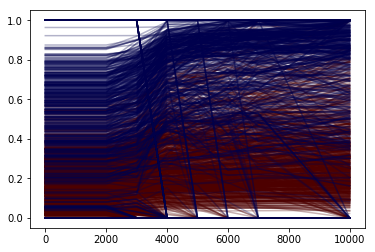

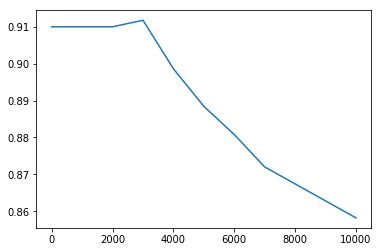

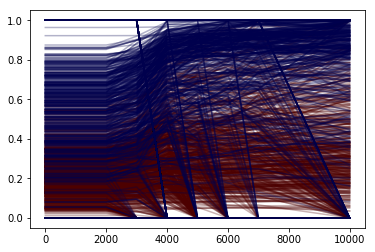

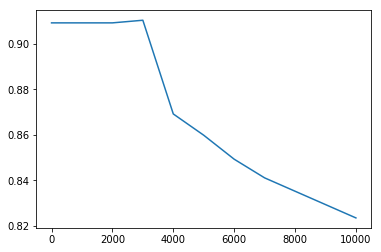

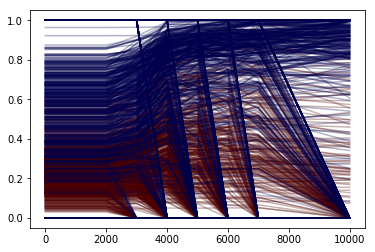

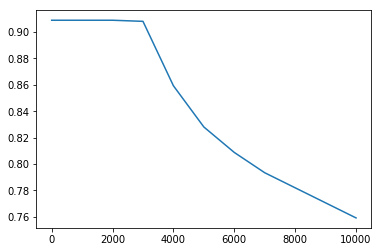

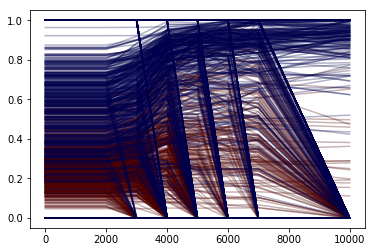

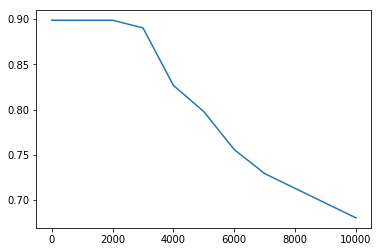

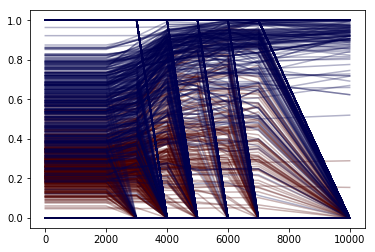

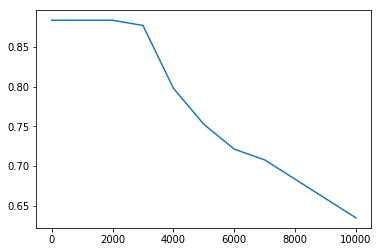

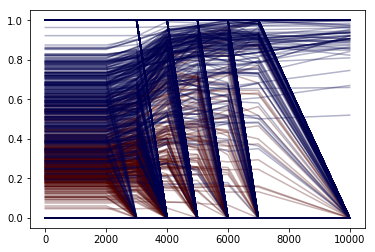

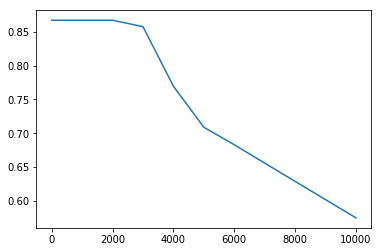

In [15]:
import pylab as plt
import numpy as np
%matplotlib inline
for i,m in enumerate(min_match_vals):
    plt.figure()
    plt.plot(ms2_vals,np.array(all_neg_curves[i]).T,color=[0.3, 0,0,0.3])
    plt.plot(ms2_vals,np.array(all_pos_curves[i]).T,color=[0.0, 0.0, 0.3, 0.3])
    plt.figure()
    plt.plot(ms2_vals,all_auc_vals[i])
    print max(all_auc_vals[i])



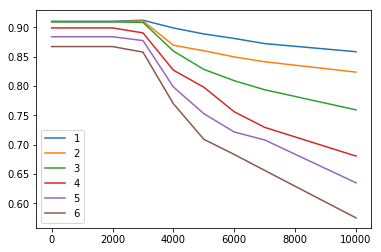

In [16]:
plt.figure()
handles = []
for i,a in enumerate(all_auc_vals):
    h, = plt.plot(ms2_vals,a,label = min_match_vals[i])
    handles.append(h)
plt.legend(handles = handles)